In [ ]:
import os
import pandas as pd
from transformers import LlamaTokenizerFast, BertTokenizerFast, AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset
from dotenv import load_dotenv
import google.generativeai as palm

#llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
# tokenizer_bloom = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# tokenizer_Bert = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")


Tokenizer by language

In [ ]:
load_dotenv()

# Configure the PaLM API key (replace 'GOOGLE_PALM_API_KEY' with whatever env var you use)
palm.configure(api_key=os.getenv('GOOGLE_PALM_API_KEY'))

def calculate_corpus_fertility_gemini(
    dataset_name,
    language_code,
    split='dev',
    max_docs=10000
):
    """
    Calculate fertility for a dataset using Google's Gemini API for token counting.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, language_code, split=split)

    total_tokens = 0
    total_words = 0

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Call Gemini 1.5-pro-002 to get token usage
        # (Set temperature=0, top_k=1, etc. to minimize additional generation.)
        response = palm.generate_text(
            model="models/gemini-1.5-pro-002",
            prompt=combined_text,
            temperature=0.0,
            top_k=1,
            top_p=1
        )

        # Safely retrieve the input token count.
        # Depending on the API version and your permissions, 
        # token usage may be in `response.metadata["token"]`.
        if response and response.metadata and "token" in response.metadata:
            # Typically "input_text_tokens" is how many tokens your prompt used
            total_tokens += response.metadata["token"].get("input_text_tokens", 0)
        else:
            # If there's an error or missing metadata, gracefully handle it
            # or raise an exception/log a warning
            print("Warning: No token usage returned. Defaulting to 0 for this example.")

        # Count words using whitespace splitting
        total_words += len(combined_text.split())

    # Compute fertility
    if total_words == 0:
        raise ValueError("Total words in the dataset is zero. Cannot compute fertility.")

    fertility = total_tokens / total_words
    return fertility


# Example usage
if __name__ == "__main__":
    dataset_name = "masakhane/afrimmlu"
    language_code = "eng"
    split = "dev"

    fertility_score = calculate_corpus_fertility_gemini(
        dataset_name, 
        language_code, 
        split=split
    )
    print("Fertility:", fertility_score)

In [ ]:
import os
import pandas as pd
import re

def extract_llm_answer(value):
        return ""

input_path = "/gemini/"
output_path = "/gemini/"

os.makedirs(output_path, exist_ok=True)
for file_name in os.listdir(input_path):
    if file_name.endswith(".tsv"):
        try:
            file_path = os.path.join(input_path, file_name)
            
            # Read the file with tab as delimiter
            df = pd.read_csv(file_path, sep='\t', on_bad_lines="skip")

            # Normalize column names (strip spaces and lowercase)
            df.columns = df.columns.str.strip().str.lower()

            # Ensure required columns exist
            if 'answer' not in df.columns or 'llm' not in df.columns:
                print(f"Skipping {file_name}: Missing required columns.")
                continue

            # Extract llm_answer from the llm column
            df['llm_answer'] = df['llm'].apply(extract_llm_answer)

            # Add accuracy column as 0 or 1
            df['accuracy'] = (df['llm_answer'] == df['answer']).astype(int)

            # Save updated file
            new_file_name = file_name.split(".")[0] + "_accuracy.csv"
            new_file_path = os.path.join(output_path, new_file_name)
            df.to_csv(new_file_path, index=False)

            print(f"Processed: {file_name}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")


In [ ]:
import pandas as pd
# List all the accuracy CSV files
accuracy_files = [f for f in os.listdir(output_path) if f.endswith('_accuracy.csv')]

# Initialize a list to hold individual DataFrames
dfs = []

# Loop through each CSV file and load it into a DataFrame
for accuracy_file in accuracy_files:
    file_path = os.path.join(output_path, accuracy_file)
    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add a column to the DataFrame for the file name (language)
        df['language'] = accuracy_file.replace('_accuracy.csv', '')  # Remove '_accuracy.csv' to get the language name
        
        # Add the DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {accuracy_file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Display the resulting DataFrame
(combined_df)

In [ ]:
combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'))

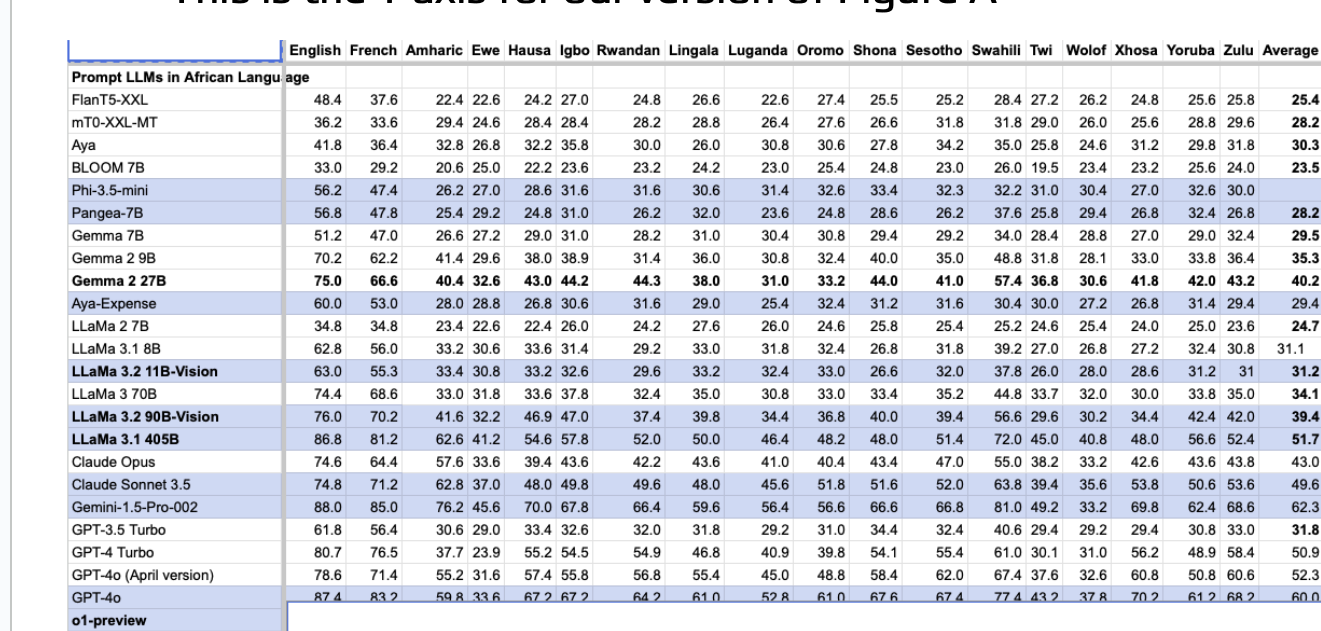

In [ ]:
aggregated_df = combined_df.groupby(['language', 'subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_fertility'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


From the MEGA Paper " We report the curves for the cases where the person coefficient |ρ| > 0.7 with a p-value of 0.05. We have combined Indic- XNLI and XNLI for a better coverage of languages.
"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.6].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df[aggregated_df['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_fertility",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Fertility Across Subjects (Pearson > 0.6)", fontsize=14)
plt.xlabel("Fertility", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
print(valid_languages)

Parity 

In [ ]:
aggregated_df_parity = combined_df.groupby(['language','subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_parity=('parity', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df_parity)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df_parity.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_parity'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.4].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df_parity[aggregated_df_parity['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_parity",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Parity Across Subjects (Pearson > 0.4)", fontsize=14)
plt.xlabel("Parity", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


" This lack of tokenization parity is not merely a curiosity: it leads to unfairness in the cost to access language models, the latency of the service and the amount of data that can be processed." This affects costs, latency, and tokenization fairness.

In [ ]:
print(valid_languages)

In [ ]:
aggregated_df = combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

Considering both intrinsic and extrinsic evaluation metrics should provide a more comprehensive understanding of a tokenizer's effectiveness and its suitability for specific applications. Should look into that